In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/implementation/packages/Basic.ipynb

In [ ]:
import torch
import torch.nn as nn
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
display.set_matplotlib_formats('svg')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [ ]:
data['class'] = data['class'].map({"bot": 1, "human": 0});
labels = torch.tensor( data['class'] ).long()

data=data.drop(['class'],axis=1) 

sample = torch.tensor(data.values).float()


In [ ]:
# create a class for the model

class ANN_CLASS_MODEL(nn.Module):
  def __init__(self,nUnits,nLayers,dropoutRate):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers
    self.dr = dropoutRate

    ### input layer
    self.layers['input'] = nn.Linear(19,nUnits)
    
    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      self.layers[f'batch{i}'] = nn.BatchNorm1d(nUnits)


    ### output layer
    self.layers['output'] = nn.Linear(nUnits,2)
  

  # forward pass
  def forward(self,x,useBatchLayer=True):
    # input layer
    x = F.relu(self.layers['input'](x))
    x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()


    # hidden layers
    for i in range(self.nLayers):
      if useBatchLayer:
        x = F.relu(self.layers[f'batch{i}'](self.layers[f'hidden{i}'](x)))
      else:
        x = F.relu(self.layers[f'hidden{i}'](x))
        x = F.dropout(x,p=self.dr,training=self.training)


    return self.layers['output'](x)

In [ ]:
ml_model = ANN_CLASS_MODEL(64,2,.20)
ml_model

ANN_CLASS_MODEL(
  (layers): ModuleDict(
    (input): Linear(in_features=19, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=64, bias=True)
    (batch0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): Linear(in_features=64, out_features=64, bias=True)
    (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
numepochs = 100

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []
ongoingAcc_test = []

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_model.parameters(),lr=0.01)


# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ml_model(sample)
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  matches = torch.argmax(yHat,axis=1) ==labels 
  matchesNumeric = matches.float()            
  ongoingAcc.append( 100*torch.mean(matchesNumeric))
  # ongoingAcc_test.append(100*torch.mean((torch.argmax(ml_model(test_data),axis=1) == test_labels).float()))


predictions = ml_model(sample)
predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

# predictions_test = ml_model(test_data)
# predlabels_test = torch.argmax(predictions_test,axis=1)
# totalacc_test = 100*torch.mean((predlabels_test == test_labels).float())

Train accuracy: 94.252%
Train Data Shape: torch.Size([100000, 19])
Train label Shape: torch.Size([100000])


Text(0.5, 1.0, 'Train Accuracy')

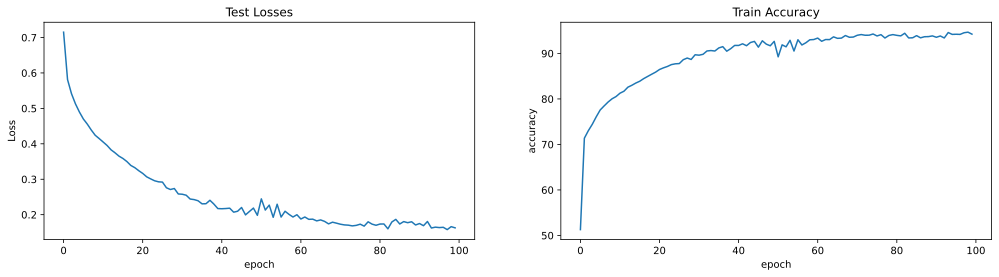

In [ ]:
# report accuracy
print('Train accuracy: %g%%' %totalacc)
# print('Test accuracy: %g%%' %totalacc_test)
print(f'Train Data Shape: {sample.shape}')
print(f'Train label Shape: {labels.shape}')
# print(f'Test Data Shape: {test_data.shape}')
# print(f'Test label Shape: {test_labels.shape}')

fig,ax = plt.subplots(1,2,figsize=(17,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Test Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train Accuracy')

# ax[2].plot(ongoingAcc_test)
# ax[2].set_ylabel('accuracy')
# ax[2].set_xlabel('epoch')
# ax[2].set_title('Test Accuracy')
# plt.show()

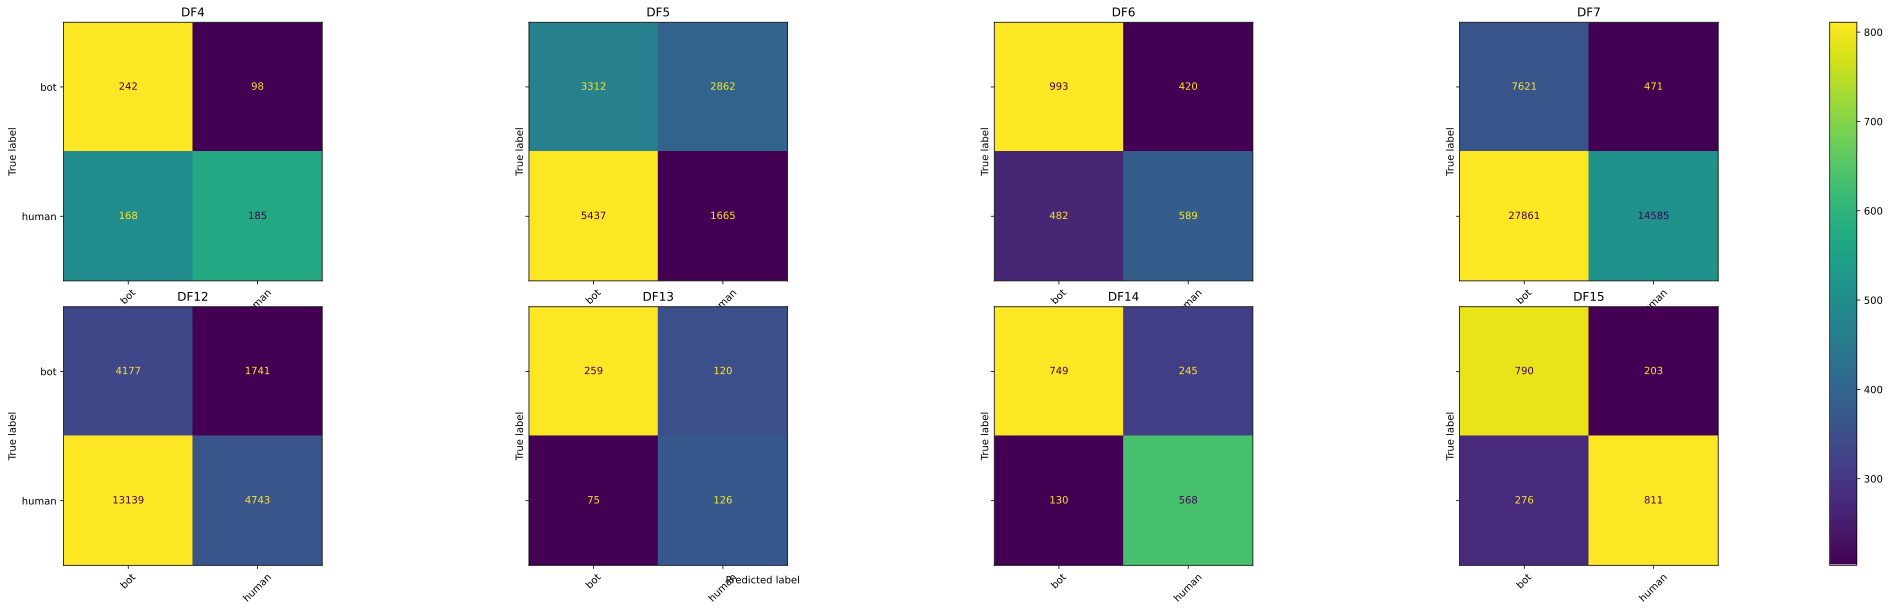

,DS,b-precision,b-recall,b-f1-score,b-total,h-precision,h-recall,h-f1-score,h-total,a-accuracy
0,DF4,0.590244,0.711765,0.645333,340,0.653710,0.524079,0.581761,353,0.616162
1,DF5,0.378558,0.536443,0.443879,6174,0.367793,0.234441,0.286353,7102,0.374887
2,DF6,0.673220,0.702760,0.687673,1413,0.583746,0.549953,0.566346,1071,0.636876
3,DF7,0.214785,0.941794,0.349796,8092,0.968717,0.343613,0.507287,42446,0.439392
4,DF12,0.241222,0.705813,0.359559,5918,0.731493,0.265239,0.389313,17882,0.374790
5,DF13,0.775449,0.683377,0.726508,379,0.512195,0.626866,0.563758,201,0.663793
6,DF14,0.852105,0.753521,0.799786,994,0.698647,0.813754,0.751820,698,0.778369
7,DF15,0.741088,0.795569,0.767363,993,0.799803,0.746090,0.772013,1087,0.769712


In [ ]:
datasets=["DF4","DF5","DF6","DF7","DF12","DF13","DF14","DF15"]
classifer_accuracy_result=pd.DataFrame(columns=["DS","b-precision","b-recall","b-f1-score","b-total","h-precision","h-recall","h-f1-score","h-total","a-accuracy"])

f, axes = plt.subplots(2, 4, figsize=(40, 10), sharey='row')

for index,dataset in enumerate(datasets):
  test = pd.read_csv(f'/content/drive/MyDrive/DATA/MetaData-Test/{dataset}.csv.gz',compression='gzip',lineterminator='\n');
  test= test.sample(frac=1).reset_index(drop=True)

  test_labels = torch.tensor(test['class'].map({"bot": 1, "human": 0}) ).long()
  test_sample = torch.tensor(test.drop(['class'],axis=1).values).float()

  model_result=ml_model(test_sample)
  classifer_accuracy_row=[dataset]
  for index_2,(key,value) in enumerate(classification_report(test_labels.detach().numpy(), torch.argmax(model_result,axis=1).detach().numpy(),output_dict=True).items()):
    if key in ["0","1"]:
      classifer_accuracy_row.extend([*value.values()])
    elif key=="accuracy":
      classifer_accuracy_row.append(value)
  classifer_accuracy_result.loc[index]=classifer_accuracy_row

  cf_matrix = confusion_matrix(test_labels.detach().numpy(),torch.argmax(model_result,axis=1).detach().numpy())
  disp = ConfusionMatrixDisplay(cf_matrix,display_labels=np.array(["bot","human"]))
  disp.plot(ax=axes[int(np.floor(index/4))][index%4], xticks_rotation=45)
  disp.ax_.set_title(dataset)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')


f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.2, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()
classifer_accuracy_result.head(10)